In [72]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg', 'retina'}

In [87]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.odr as odr
from scipy.optimize import curve_fit

In [55]:
hubble_constant = 75 * 3.24078e-20
speed_of_light = 3e8

Fitting a six parameter $\Lambda CDM$ model
-----------------------------------------

The model is specified as follows:

$$
    H(a) \equiv \frac{\dot{a}}{a} = H_0 \sqrt{ \left [ (\Omega_c + \Omega_b) a^{-3} + \Omega_{rad} a^{-4} + \Omega_k a^{-2} + \Omega_{DE} a^{-3(1+w)} \right ]}~. ~ ~ ~ ~ (1)
$$

We also need to fit for the effective luminosity of the supernovae, using

$$
    f = \frac{L_{peak}}{4\pi\left[R_0\eta\right]^2(1+z)^2}~, ~ ~ ~ ~ (2)
$$

with

$$
    m = m_0 - 2.5\log_{10}(f)~, ~ ~ ~ ~ (3)
$$

and

$$
    R_0\eta = c\int^z_0 \frac{\mathrm{d}z'}{H(z')}~. ~ ~ ~ ~ (4)
$$

which assumes $k=0$ and as such we reduce to a 6 parameter model again.

Below functions are set up to enable us to fit the data to the equations given above.

In [56]:
def a_of_z(z):
    """Simple function that gives a(z) = 1/(1+z)"""
    return 1./(1+z)

In [57]:
def h_of_a(a, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """Implementation of (1) at the top. Returns H(a)"""
    return H0 * np.sqrt((omega_c+omega_b)*(a**-3) + omega_rad*(a**-4) + omega_k*(a**-2) + omega_de*(a**(-3*(1+w))))

In [58]:
def h_of_z(z, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """Implementation of (1) at the top. Returns H(a)"""
    a = a_of_z(z)
    return H0 * np.sqrt((omega_c+omega_b)*(a**-3) + omega_rad*(a**-4) + omega_k*(a**-2) + omega_de*(a**(-3*(1+w))))

In [111]:
def h_of_z_inverse(z, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """1/h_of_z"""
    return 1/h_of_z(z, omega_c, omega_b, omega_rad, omega_k, omega_de, w, H0)

In [112]:
def f_of_z(z, lpeak, r_eta):
    """Implementation of (2) at the top. Returns flux as a function of redshift"""
    return lpeak/(4*np.pi*((r_eta)**2)*((1+z)**2))

In [113]:
def mag_of_f(f, m0=-13):
    """Implementation of (3) at the top. Returns magnitude as a function of flux"""
    return m0 - 2.5*np.log10(f)

In [114]:
def r_eta_int(z, h_of_z, omega_c=0, omega_b=0.3, omega_rad=0, omega_k=0, omega_de=0.7, w=-1, H0=hubble_constant):
    """Implementation of (4) at the top. Returns R0 eta as a function of z. h_of_z callable."""
    oarray = np.empty_like(z)
    
    for i in range(len(z)):
        output = si.quad(h_of_z_inverse, 0, z[i], args=(omega_c, omega_b, omega_rad, omega_k, omega_de, w, H0))
        oarray[i] = speed_of_light*output[0]
        
    return oarray

In [115]:
def read_data(fname="data/z_data.csv"):
    """Reads data

    Output
    ------
    z: z array
    m: magnitude array
    m_err: magnitude error array"""
    
    raw = np.loadtxt(fname, delimiter=" ", usecols=(1,2,3))
    return raw[:,0], raw[:,1], raw[:,2]

# How to fit the data?

There needs to be some sort of outline here. What we want is a function that gets magnitude $m$ as a function of $z$ and all of the parameters we care about.

1. Function should have inputs for lpeak, omega_c, omega_b, omega_rad, omega_de and w.
2. Function should pass the latter 5 to r_eta_int to get $R_0 \eta$ as a function of $z$
3. This should be passed to f_of_z to get $f(z, L_{peak}, R_0 \eta)$
4. Pass this to mag_of_f to get $m(z, parameters)$.

We will be using scipy.odr to fit the data in case we have information about uncertainty in $z$.

Issue: **We need to impose that the sum of the $\Omega$s is 1**

In [123]:
def for_fitting(B, z):
    """Implemenets the outline given above.
    
    B is an array: [lpeak, omega_c, omega_b, omega_rad, omega_de and w]"""
    reta = r_eta_int(z, h_of_z=h_of_z, omega_c=0, omega_b=(1-B[1]), omega_rad=0, omega_k=0,
                     omega_de=B[1], w=-1, H0=hubble_constant)
    return mag_of_f(f_of_z(z, B[0], reta))

In [124]:
z, mag, mag_err = read_data()

In [125]:
my_model = odr.Model(for_fitting)
my_data = odr.RealData(z, mag, sy=mag_err)

my_odr = odr.ODR(my_data, my_model, beta0=[4e30, 0.7])
my_odr.set_job(fit_type=2)  # no xvar

my_output = my_odr.run()

/Users/josh/Documents/superncosmo/env/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt
/Users/josh/Documents/superncosmo/env/lib/python3.5/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


/Users/josh/Documents/superncosmo/env/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


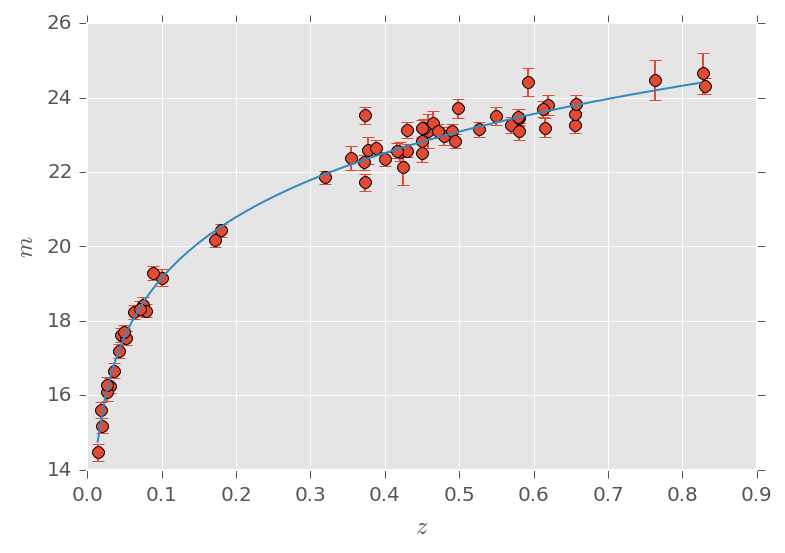

In [126]:
plt.errorbar(z, mag, yerr=mag_err, fmt='o')

z_for_plot = np.arange(min(z), max(z), 0.01)
m_for_plot = for_fitting(my_output.beta, z_for_plot)
plt.plot(z_for_plot, m_for_plot)
plt.xlabel("$z$")
plt.ylabel("$m$")
plt.show()

In [127]:
names = ['lpeak', 'omega_c', 'omega_b', 'omega_rad', 'omega_de', 'w']
for i in range(len(names)):
    print(names[i], " ", my_output.beta[i])

lpeak   3.0475322521e+38
omega_c   0.681755887075


IndexError: index 2 is out of bounds for axis 0 with size 2